# Imports

In [85]:
import psycopg2 as pg
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [116]:
# configurações globais
sns.set_theme()                                                   # gráfico
plt.rcParams['figure.figsize'] = [20, 12]                         # gráfico

# 1 Coleta dos Dados

In [2]:
# Credenciais
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
password = 'cdspa'

In [4]:
conn = pg.connect(user = username,
                  password = password,
                  host = host,
                  port = port,
                  database = database)

## 1.1 Consulta do Schema

In [33]:
cursor = conn.cursor()

query_schema = """
    SELECT nspname
    FROM pg_catalog.pg_namespace
"""

cursor.execute(query_schema)

record = cursor.fetchall()
cursor.close()
conn.close()

InterfaceError: connection already closed

In [11]:
record

[('pg_toast',),
 ('pg_temp_1',),
 ('pg_toast_temp_1',),
 ('pg_catalog',),
 ('information_schema',),
 ('public',),
 ('pa004',),
 ('pg_temp_4',),
 ('pg_toast_temp_4',),
 ('pa005',),
 ('pg_temp_9',),
 ('pg_toast_temp_9',)]

## 1.2 Consulta das Tabelas

In [25]:
cursor = conn.cursor()

query_table = """
select tablename
from pg_catalog.pg_tables pt 
where  schemaname = 'pa004'
"""

cursor.execute(query_table)
record = cursor.fetchall()
print(record)

cursor.close()
conn.close()

[('users',), ('vehicle',), ('insurance',)]


## 1.3 Coleta de Dados usando o Psycopg2

In [29]:
cursor = conn.cursor()

query = """
SELECT
*
FROM pa004.users u
WHERE u.age > 44
LIMIT 10
"""

cursor.execute(query)
record = cursor.fetchall()
print(record)

cursor.close()
conn.close()

[(2, 'Male', 76, 3.0, 26.0), (3, 'Male', 47, 28.0, 26.0), (8, 'Female', 56, 28.0, 26.0), (11, 'Female', 47, 35.0, 124.0), (14, 'Male', 76, 28.0, 13.0), (15, 'Male', 71, 28.0, 30.0), (20, 'Female', 60, 33.0, 124.0), (21, 'Male', 65, 28.0, 124.0), (22, 'Male', 49, 28.0, 124.0), (27, 'Female', 51, 28.0, 124.0)]


In [31]:
pd.DataFrame(record)

,0,1,2,3,4
0,2,Male,76,3.0,26.0
1,3,Male,47,28.0,26.0
2,8,Female,56,28.0,26.0
3,11,Female,47,35.0,124.0
4,14,Male,76,28.0,13.0
5,15,Male,71,28.0,30.0
6,20,Female,60,33.0,124.0
7,21,Male,65,28.0,124.0
8,22,Male,49,28.0,124.0
9,27,Female,51,28.0,124.0


## 1.4 Coleta de Dados usando Pandas

In [5]:
query = """
SELECT
*
FROM pa004.users u
WHERE u.age > 44
LIMIT 10
"""

pd.read_sql(query, conn)

/home/jonas/anaconda3/envs/health_insurance/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,id,gender,age,region_code,policy_sales_channel
0,2,Male,76,3.0,26.0
1,3,Male,47,28.0,26.0
2,8,Female,56,28.0,26.0
3,11,Female,47,35.0,124.0
4,14,Male,76,28.0,13.0
5,15,Male,71,28.0,30.0
6,20,Female,60,33.0,124.0
7,21,Male,65,28.0,124.0
8,22,Male,49,28.0,124.0
9,27,Female,51,28.0,124.0


In [57]:
query = """
SELECT
*
FROM pa004.users u LEFT JOIN pa004.vehicle v ON (u.id = v.id)
                   LEFT JOIN pa004.insurance i ON (u.id = i.id)
"""

df = pd.read_sql(query, conn)
df.head()

/home/jonas/anaconda3/envs/health_insurance/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


In [58]:
# Drop das Colunas "id" que estão repetidas
df['id_aux'] = df['id'].apply(np.mean, axis=1)
df = df.drop(columns='id', axis=1)

df.insert(0, 'id', df['id_aux'].astype('int64')) 
df = df.drop(columns='id_aux', axis=1)

In [59]:
df.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


In [63]:
df.to_csv('datasets/data_raw.csv', index=False)

# 2 Análise Descritiva

In [64]:
df2 = pd.read_csv('datasets/data_raw.csv')

In [65]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


## 2.1 Dimensões dos dados

In [75]:
print(f'Linhas: {df2.shape[0]}')
print(f'Colunas: {df2.shape[1]}')

Linhas: 381109
Colunas: 12


## 2.2 Tipos das Variáveis

In [67]:
df2.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 2.3 Checagem de NA's

In [78]:
df2.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 2.4 Estatística Descritiva

In [80]:
df2.describe()

,id,age,region_code,policy_sales_channel,driving_license,previously_insured,annual_premium,vintage,response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,26.388807,112.034295,0.997869,0.458210,30564.389581,154.347397,0.122563
std,110016.836208,15.511611,13.229888,54.203995,0.046110,0.498251,17213.155057,83.671304,0.327936
min,1.000000,20.000000,0.000000,1.000000,0.000000,0.000000,2630.000000,10.000000,0.000000
25%,95278.000000,25.000000,15.000000,29.000000,1.000000,0.000000,24405.000000,82.000000,0.000000
50%,190555.000000,36.000000,28.000000,133.000000,1.000000,0.000000,31669.000000,154.000000,0.000000
75%,285832.000000,49.000000,35.000000,152.000000,1.000000,1.000000,39400.000000,227.000000,0.000000
max,381109.000000,85.000000,52.000000,163.000000,1.000000,1.000000,540165.000000,299.000000,1.000000


In [84]:
df2_cat = df2.select_dtypes(include=['object'])
df2_cat.head()

,gender,vehicle_age,vehicle_damage
0,Male,< 1 Year,Yes
1,Female,1-2 Year,No
2,Female,< 1 Year,No
3,Female,< 1 Year,No
4,Male,1-2 Year,Yes


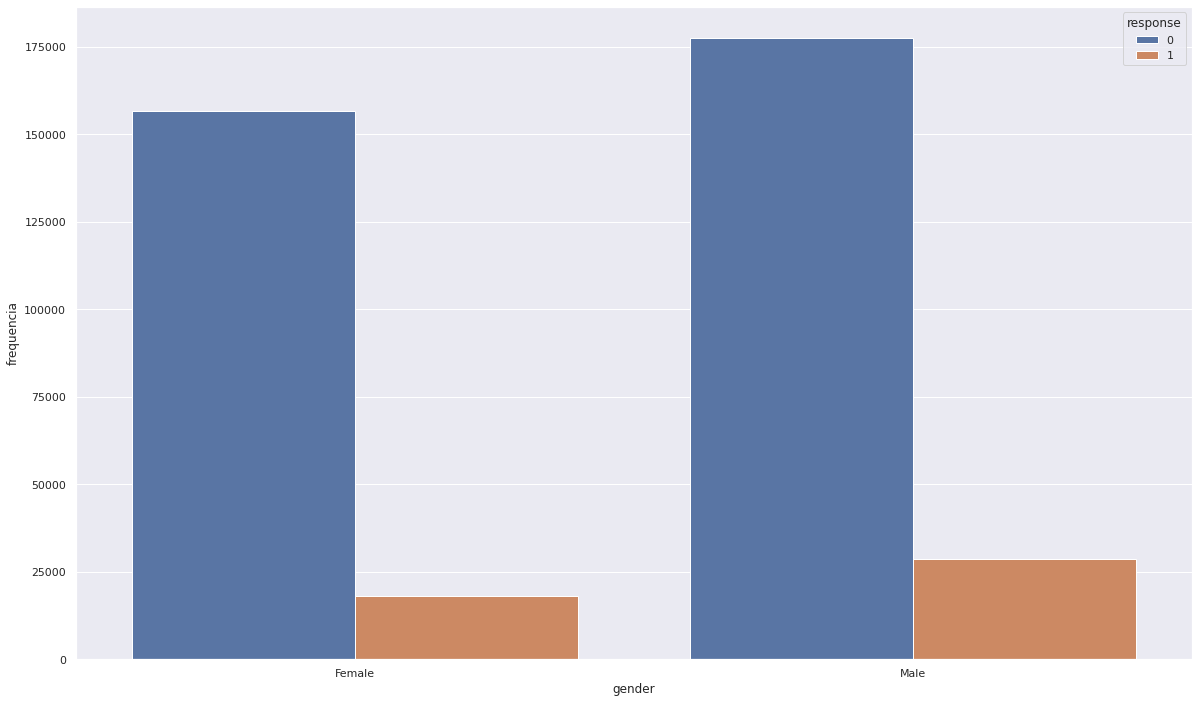

In [124]:
# gender x response
df_aux = df[['id', 'gender', 'response']].groupby(['gender', 'response']).count().reset_index()
df_aux['frequencia'] = df_aux['id']
sns.barplot(data=df_aux, x='gender', y='frequencia', hue='response');

<AxesSubplot:xlabel='vehicle_age', ylabel='frequencia'>

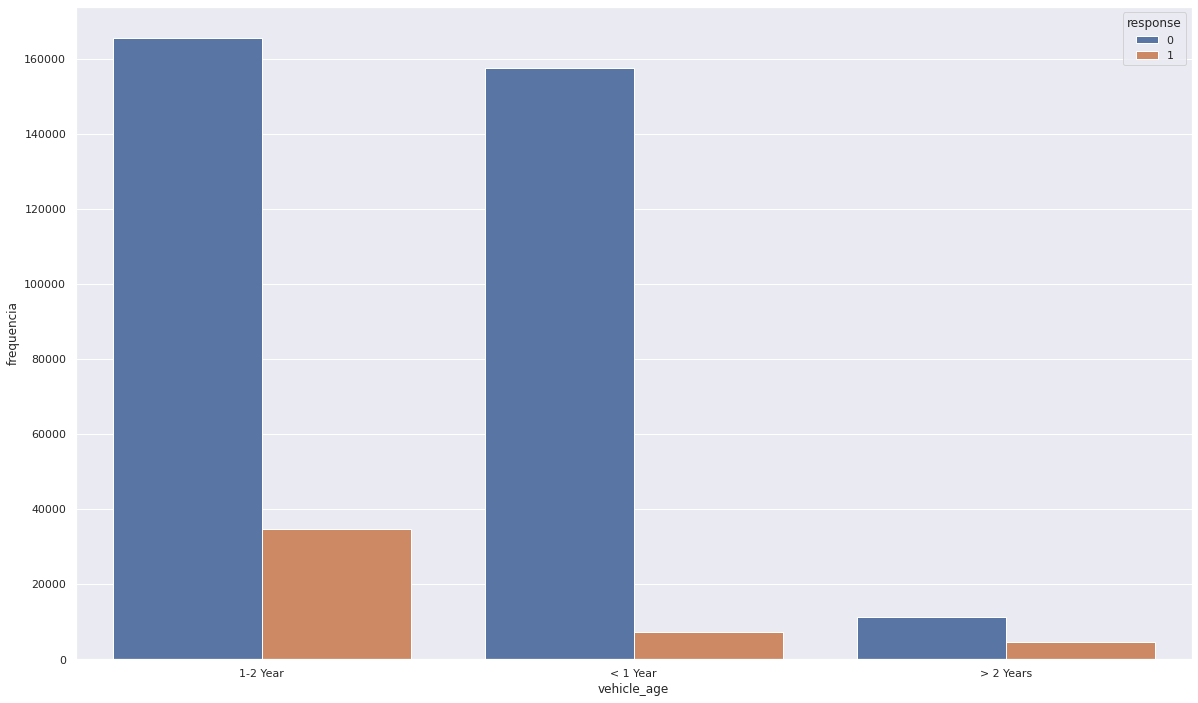

In [126]:
# vehicle_age x response
df_aux = df[['vehicle_age', 'response', 'id']].groupby(['vehicle_age', 'response']).count().reset_index()
df_aux['frequencia'] = df_aux['id']
sns.barplot(data=df_aux, x='vehicle_age', y='frequencia', hue='response')

<AxesSubplot:xlabel='vehicle_damage', ylabel='frequencia'>

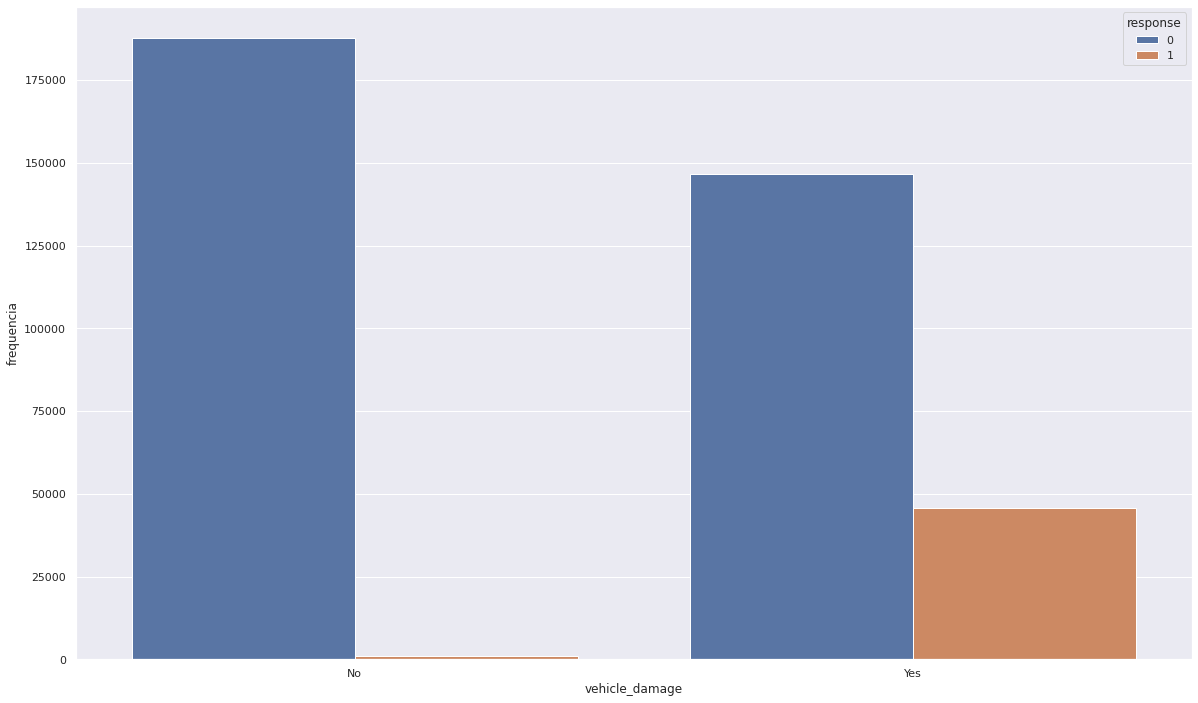

In [127]:
# vehicle_damage x response
df_aux = df[['vehicle_damage', 'response', 'id']].groupby(['vehicle_damage', 'response']).count().reset_index()
df_aux['frequencia'] = df_aux['id']
sns.barplot(data=df_aux, x='vehicle_damage', y='frequencia',hue='response')

# 3 Feature Engineering